### 1) Overall configurations 

In [1]:
import os
import os.path
import pandas as pd
from pprint import pprint

# Example large data
instance_settings_path = "C:/Users/LocalAdmin/IdeaProjects/slevels/src/main/resources/week/enforce_service_levels.json"

### 2) Loading the instance data

In [2]:
import json

def load_json(path):
    """Read json file and return dictionary"""

    # Add .json to the end of file if needed
    if path.find(".json") < 0:
        path = path + ".json"

    # Read JSON file
    with open(path) as data_file:
        data_loaded = json.load(data_file)

    return data_loaded

instances_dic = load_json(instance_settings_path)

# Folder where results will be saved
result_folder = instances_dic["result_folder"]
request_log_folder = result_folder + "/request_track"
violin_log_folder = result_folder + "violin_plot/"

# Folder where instances are located
instances_folder = instances_dic["instances_folder"]

# File name aggregated data
instance_name = instances_dic["instance_name"]


print("########### INSTANCE SETTINGS ##################################################")
pprint(instances_dic)

########### INSTANCE SETTINGS ##################################################
{'adjacency_matrix_file': 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/data/out/manhattan/network_info/adjacency_matrix.csv',
 'distances_file': 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/data/out/manhattan/distance/dist_matrix_m.csv',
 'durations_file': 'C:/Users/LocalAdmin/OneDrive/leap_forward/street_network_server/tenv/data/out/manhattan/distance/dist_matrix_duration_s.csv',
 'instance_description': 'User can have their times worsened',
 'instance_name': 'ENFORCE',
 'instances_folder': 'C:/Users/LocalAdmin/IdeaProjects/slevels/instance_output/enforce_sl/',
 'labels': {'BA': 'batch_duration',
            'CD': 'contract_duration',
            'CS': 'customer_segmentation',
            'CT': 'clear_target_list_every_round',
            'HE': 'rebalance_heuristic',
            'ID': 'instance_description',
            'IF': 'initial_fleet',
            '

### Violin plot (FIRST X SECOND and Initial X Third-party fleet)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
sns.despine(left=True)

def violin(df_user_track, violin_log_folder, file_name, replace=False, file_extension = 'pdf'):
    
    font_ticks = 16
    font_axis = 18
    font_title = 20
    # Create directory
    if not os.path.exists(violin_log_folder):
        os.makedirs(violin_log_folder)
    
    output_file_name = "{}{}.{}".format(violin_log_folder, file_name, file_extension)
    
    # Stop generation if already generated 
    if os.path.isfile(output_file_name) and not replace:
        return
    
    
    # New column labels (variable names are column names)
    service_level = "Pickup deadline"
    service = "User serviced by" 
    sq_class = "SQ Class"
    pk_delay = "Pickup delay (min)"
    
    # New data nomenclature
    dic_sq_class = {"A":"Business",
                    "B":"Standard",
                    "C":"Low-cost"}    
    sq_categories= list(dic_sq_class.values())
    
    # Was the user pickup deadline extended? YES = UNMET in dataframe
    met = "Shortest"
    unmet = "Extended"
    dic_slevel = {"FIRST":met,
                  "SECOND":unmet}
    
    # Was the user picked up by a third-party vehicle? YES = FREELANCE in dataframe
    fleet = "Initial fleet"
    freelance="Third-party fleet"
    rejected="Rejected"
    dic_fleet = {"FLEET":fleet,
                 "DENIED":rejected}
    
    # Replacing column names
    df_delay = df_user_track.rename(index=str,
                                    columns={"delay_pk":pk_delay,
                                             "class": sq_class,
                                             "service":service,
                                             "service_level":service_level})
    
    
    category_segmentation = pd.api.types.CategoricalDtype(categories=sq_categories, ordered=True)
    df_delay[sq_class].replace(dic_sq_class, inplace=True)
    
    # Renaming data and applying aliases
    # a[key_cs] = a[key_cs].map(lambda e:dict_segmentation[e])
    df_delay[sq_class] = df_delay[sq_class].astype(category_segmentation)

    # Replacing classes
    df_delay[sq_class].replace(dic_sq_class, inplace=True)

    # Getting percentage of users in each end of the service rate
    value_counts_sl = df_delay[service_level].value_counts()
    met_n = value_counts_sl.get("FIRST",0)
    unmet_n = value_counts_sl.get("SECOND",0)
    sl_map = {  "FIRST": "1st tier ({:.2%})".format(met_n/(met_n+unmet_n)),
              "SECOND": "2nd tier ({:.2%})".format(unmet_n/(met_n+unmet_n))}
    df_delay[service_level].replace(sl_map, inplace=True)
    
    ### Getting percentage of vehicle fleet serviced by each vehicle type
    value_counts_fleet = df_delay[service].value_counts()
    fleet_n = value_counts_fleet.get("FLEET", 0)
    freelance_n = value_counts_fleet.get("FREELANCE", 0)
    denied_n = value_counts_fleet.get("DENIED", 0)
    # How many users (%) serviced by each vehicle
    fleet_map = {    "FLEET": fleet_n/(fleet_n+freelance_n+denied_n),
                 #"FREELANCE": freelance_n/(fleet_n+freelance_n+denied_n),
                    "DENIED": (denied_n + freelance_n)/(fleet_n+freelance_n+denied_n)}
    #df_delay[service].replace(fleet_map, inplace=True)

    # Customized palette
    #palette_color = {initial_percentage:'#1d91c0', freelance_percentage:'#edf8b1'}

    g = sns.catplot(x=sq_class,
                     y=pk_delay,
                     hue=service_level,
                     col=service,
                     data=df_delay,
                     kind="violin",
                     cut=0,
                     bw=.2,
                     palette="Pastel1")

    # Formatting tick shape (from secs to mins)
    min_y = 0
    max_y = 660 # Goes until eleven to fit data labels
    step_y = 60
    g.set(yticks=[i for i in range(min_y, max_y+step_y, step_y)])
    g.set(yticklabels=[i for  i in range(0, 11)])
    
    # Setting tick style
    g.set_xlabels(fontweight="bold", fontsize=font_axis, labelpad =10)
    g.set_ylabels(fontsize=font_ticks)
    
    plt.setp(g._legend.get_title(), fontsize=font_axis, fontweight="bold")
    plt.setp(g._legend.get_texts(), fontsize=font_ticks)
    plt.setp(g._legend, bbox_to_anchor=(1.06, 0.5))
    #plt.subplots_adjust(hspace=0.6, wspace=0.1)

    # Setting column headers
    # Example to use rows, cols and Latex math
    # g.set_titles(r"$\bf{{Service\;rate:}}$" + "{row_name}\n"+ r"$\bf{{Service\;level:}}$ {col_name}")
    g.set_titles("{col_name}")

    # Loop catplot columns
    sl_unmet = sl_map['SECOND']
    for col, fleet_type in enumerate(dic_fleet.keys()):
        
        # Create column titles
        g.axes.flat[col].set_title(dic_fleet[fleet_type], fontweight="bold", fontsize=font_title, pad=28)
        g.axes.flat[col].text(0.1, max_y + 15, "(serviced {:.2%} requests)".format(fleet_map[fleet_type]), fontsize=font_ticks)
        g.axes.flat[col].tick_params(axis='both', labelsize=font_ticks)
        filter_unmet = (df_delay[service_level]==sl_unmet) & (df_delay[service]==fleet_type)
        # User count (per fleet type) who had their pickup deadlines extended
        extended_count = dict(df_delay[sq_class][filter_unmet].value_counts())
        
        # Place data label over the user who waited the longest (upmost y coordinate)
        max_pkdelay_extended = dict(df_delay[filter_unmet].groupby(sq_class)[pk_delay].max())
        
        for sq_i, sq in enumerate(sq_categories):
            
            # How many users from sq had to wait more?
            extended_sq = int(extended_count.get(sq, 0))
            
            if extended_sq > 0:
                extended_sq_max = max_pkdelay_extended[sq]
                up_padding = 10
                pos_y = extended_sq_max + up_padding
                
                
                g.axes.flat[col].text(sq_i+0.08,
                                      pos_y,
                                      "n={}".format(extended_sq),fontsize=font_ticks)

    print(f"Saving figure at \"{output_file_name}\...")
    plt.savefig(output_file_name, bbox_inches="tight")
    
    # Close figure
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [4]:
def read_request_track(folder, request_track_experiment_label):
    experiment_path = "{}request_track/{}.csv".format(folder, request_track_experiment_label)
    return pd.read_csv(experiment_path,  parse_dates = True, comment = "#")

def concat_dfs(user_track_dfs, method_labels):

    df_compare_list = []

    for method_label, df_user_track in zip(method_labels, user_track_dfs):
        df_delay = df_user_track[["delay_pk", "class", "service", "service_level"]].copy()
        df_delay["method"] = method_label
        df_compare_list.append(df_delay)

    df_compare = pd.concat(df_compare_list)

    return df_compare

def add_labels(df_user_track, dict_sl_class, dict_slevel, dict_fleet, headers):
    df_user_track = df_user_track.rename(index=str, columns=headers)
    sq_categories= list(dict_sl_class.values())
    category_segmentation = pd.api.types.CategoricalDtype(categories=sq_categories, ordered=True)
    df_user_track[headers["class"]].replace(dict_sl_class, inplace=True)
    df_user_track[headers["service_level"]].replace(dict_slevel, inplace=True)
    df_user_track[headers["service"]].replace(dict_fleet, inplace=True)
    return df_user_track


def generate_violin(df_user_track,  x, y, hue, col, violin_log_folder, file_name, replace=False, file_extension = 'pdf'):

    font_ticks = 16
    font_axis = 18
    font_title = 20
    # Create directory
    if not os.path.exists(violin_log_folder):
        os.makedirs(violin_log_folder)

    output_file_name = "{}{}.{}".format(violin_log_folder, file_name, file_extension)

    # Stop generation if already generated
    if os.path.isfile(output_file_name) and not replace:
        return

    g = sns.catplot(x=sq_class,
                     y=pk_delay,
                     hue=service_level,
                     col=service,
                     data=df_delay,
                     kind="violin",
                     cut=0,
                     bw=.2,
                     palette="Pastel1")

    # Formatting tick shape (from secs to mins)
    min_y = 0
    max_y = 660 # Goes until eleven to fit data labels
    step_y = 60
    g.set(yticks=[i for i in range(min_y, max_y+step_y, step_y)])
    g.set(yticklabels=[i for  i in range(0, 11)])

    # Setting tick style
    g.set_xlabels(fontweight="bold", fontsize=font_axis, labelpad =10)
    g.set_ylabels(fontsize=font_ticks)

    plt.setp(g._legend.get_title(), fontsize=font_axis, fontweight="bold")
    plt.setp(g._legend.get_texts(), fontsize=font_ticks)
    plt.setp(g._legend, bbox_to_anchor=(1.06, 0.5))
    #plt.subplots_adjust(hspace=0.6, wspace=0.1)

    # Setting column headers
    # Example to use rows, cols and Latex math
    # g.set_titles(r"$\bf{{Service\;rate:}}$" + "{row_name}\n"+ r"$\bf{{Service\;level:}}$ {col_name}")
    g.set_titles("{col_name}")

    # Loop catplot columns
    sl_unmet = sl_map['SECOND']
    for col, fleet_type in enumerate(dic_fleet.keys()):

        # Create column titles
        g.axes.flat[col].set_title(dic_fleet[fleet_type], fontweight="bold", fontsize=font_title, pad=28)
        g.axes.flat[col].text(0.1, max_y + 15, "(serviced {:.2%} requests)".format(fleet_map[fleet_type]), fontsize=font_ticks)
        g.axes.flat[col].tick_params(axis='both', labelsize=font_ticks)
        filter_unmet = (df_delay[service_level]==sl_unmet) & (df_delay[service]==fleet_type)
        # User count (per fleet type) who had their pickup deadlines extended
        extended_count = dict(df_delay[sq_class][filter_unmet].value_counts())

        # Place data label over the user who waited the longest (upmost y coordinate)
        max_pkdelay_extended = dict(df_delay[filter_unmet].groupby(sq_class)[pk_delay].max())

        for sq_i, sq in enumerate(sq_categories):

            # How many users from sq had to wait more?
            extended_sq = int(extended_count.get(sq, 0))

            if extended_sq > 0:
                extended_sq_max = max_pkdelay_extended[sq]
                up_padding = 10
                pos_y = extended_sq_max + up_padding


                g.axes.flat[col].text(sq_i+0.08,
                                      pos_y,
                                      "n={}".format(extended_sq),fontsize=font_ticks)

    print(f"Saving figure at \"{output_file_name}\...")
    plt.savefig(output_file_name, bbox_inches="tight")

    # Close figure
    plt.clf()

## User track data dictionaries

In [5]:
dict_sl_class = {
    "A":"Business",
    "B":"Standard",
    "C":"Low-cost"
}

dict_fleet = {
    "FLEET": "Company",
    "FREELANCE": "Freelance",
    "DENIED": "Denied"
}

dict_sl_tier = {
    "FIRST":"1st tier",
    "SECOND":"2nd tier"
}

headers= {
    "service_level": "Pickup deadline",
    "class": "SQ Class",
    "delay_pk": "Pickup delay (min)",
    "service": "Service",
    "method": "Method"
 }

## Comparison Status Quo X Enforce Service Levels (Fixed Fleet)
Join two experimental results from different methods:

In [6]:
status_quo = "IN-ENFORCE_BA-30_ST-86400_MR-1000_IF-1000_MC-4_CS-BB_CD-0_SR-S1_VH_SD_RE-OP_OPT-JAVIER"
enforce_sl = "IN-ENFORCE_BA-30_ST-86400_MR-1000_IF-1000_MC-4_CS-BB_CD-0_SR-S1_VH_SD_RE-OP_OPT-JAVIERSL"
request_track_experiment_labels = ["Status quo", "Enforce SL"]

df_methods_list = [read_request_track(instances_folder, experiment) for experiment in [status_quo, enforce_sl]]
df_methods = concat_dfs(df_methods_list, request_track_experiment_labels)
df_methods = add_labels(df_methods, dict_sl_class, dict_sl_tier, dict_fleet, headers)

df_methods

,Pickup delay (min),SQ Class,Service,Pickup deadline,Method
0,84,Business,Company,1st tier,Status quo
1,50,Business,Company,1st tier,Status quo
2,30,Business,Company,1st tier,Status quo
3,41,Business,Company,1st tier,Status quo
4,70,Business,Company,1st tier,Status quo
...,...,...,...,...,...
210264,381,Low-cost,Company,1st tier,Enforce SL
210265,372,Low-cost,Company,1st tier,Enforce SL
210266,358,Low-cost,Company,1st tier,Enforce SL
210267,175,Business,Company,1st tier,Enforce SL


In [7]:
from collections import defaultdict

# Service filters
filter_freelance = df_methods[headers["service"]]==dict_fleet["FREELANCE"]
filter_denied = df_methods[headers["service"]]==dict_fleet["DENIED"]
filter_fleet = df_methods[headers["service"]]==dict_fleet["FLEET"]

# Service filters
filter_first = df_methods[headers["service_level"]]==dict_sl_tier["FIRST"]
filter_second = df_methods[headers["service_level"]]==dict_sl_tier["SECOND"]

df_rejected = df_methods[filter_freelance | filter_denied]
rejected_count = dict(df_rejected[headers["method"]].value_counts())

df_serviced = df_methods[filter_fleet]
serviced_count = dict(df_serviced[headers["method"]].value_counts())

df_first = df_methods[filter_fleet & filter_first]
first_count = dict(df_first[headers["method"]].value_counts())

df_second = df_methods[filter_fleet & filter_second]
second_count = dict(df_second[headers["method"]].value_counts())

dict_status = {
    "Serviced":df_serviced,
    "Rejected":df_rejected,
    "First-tier": df_first,
    "Second-tier":df_second
}
dict_methods = defaultdict(list)
for method in request_track_experiment_labels:
    dict_methods["Serviced"].append(serviced_count[method])
    dict_methods["Rejected"].append(rejected_count[method])
    dict_methods["First-tier"].append(first_count[method])
    dict_methods["Second-tier"].append(second_count[method])

df_summary = pd.DataFrame.from_dict(dict_methods)
df_summary.set_index(pd.Index(request_track_experiment_labels))

,Serviced,Rejected,First-tier,Second-tier
Status quo,192332,17937,147283,45049
Enforce SL,159916,50353,126220,33696


### Result summary per service level class

In [8]:
def filter_class(df, sl_class):
    filter = df[headers["class"]] == sl_class
    return df[filter]

def value_counts_dict(df, sl_class):
    df_class = filter_class(df, sl_class)
    counts = dict(df_class[headers["method"]].value_counts())
    print(sl_class, counts)
    return counts

dict_methods_class = defaultdict(list)
dict_all = defaultdict(list)
for status, df in dict_status.items():
    for method in request_track_experiment_labels:
        for sl_class in dict_sl_class.values():

            dict_methods_class["Status"].append(status)
            dict_methods_class["Method"].append(method)
            dict_methods_class["Class"].append(sl_class)
            dict_methods_class["Count"].append(value_counts_dict(df, sl_class).get(method,0))


df_summary_class = pd.DataFrame.from_dict(dict_methods_class)
df_summary_class.set_index(["Class", "Status", "Method"], inplace=True)
df_summary_class.sort_index(inplace=True)
df_summary_class

Business {'Enforce SL': 31564, 'Status quo': 30546}
Standard {'Status quo': 131965, 'Enforce SL': 112756}
Low-cost {'Status quo': 29821, 'Enforce SL': 15596}
Business {'Enforce SL': 31564, 'Status quo': 30546}
Standard {'Status quo': 131965, 'Enforce SL': 112756}
Low-cost {'Status quo': 29821, 'Enforce SL': 15596}
Business {'Status quo': 4485, 'Enforce SL': 3467}
Standard {'Enforce SL': 30240, 'Status quo': 11031}
Low-cost {'Enforce SL': 16646, 'Status quo': 2421}
Business {'Status quo': 4485, 'Enforce SL': 3467}
Standard {'Enforce SL': 30240, 'Status quo': 11031}
Low-cost {'Enforce SL': 16646, 'Status quo': 2421}
Business {'Enforce SL': 30544, 'Status quo': 11337}
Standard {'Status quo': 106125, 'Enforce SL': 80080}
Low-cost {'Status quo': 29821, 'Enforce SL': 15596}
Business {'Enforce SL': 30544, 'Status quo': 11337}
Standard {'Status quo': 106125, 'Enforce SL': 80080}
Low-cost {'Status quo': 29821, 'Enforce SL': 15596}
Business {'Status quo': 19209, 'Enforce SL': 1020}
Standard {'En

Count
Class    Status      Method            
Business First-tier  Enforce SL   30544
                     Status quo   11337
         Rejected    Enforce SL    3467
                     Status quo    4485
         Second-tier Enforce SL    1020
                     Status quo   19209
         Serviced    Enforce SL   31564
                     Status quo   30546
Low-cost First-tier  Enforce SL   15596
                     Status quo   29821
         Rejected    Enforce SL   16646
                     Status quo    2421
         Second-tier Enforce SL       0
                     Status quo       0
         Serviced    Enforce SL   15596
                     Status quo   29821
Standard First-tier  Enforce SL   80080
                     Status quo  106125
         Rejected    Enforce SL   30240
                     Status quo   11031
         Second-tier Enforce SL   32676
                     Status quo   25840
         Serviced    Enforce SL  112756
                     Status quo  131965

       Pickup delay (min)
count       352248.000000
mean           208.512202
std            119.430185
min              1.000000
25%            105.000000
50%            185.000000
75%            304.000000
max            420.000000


<Figure size 432x288 with 0 Axes>

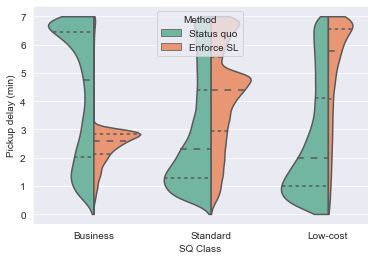

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")
sns.despine(left=True)
import numpy as np

print(df_serviced.describe())

fig, ax = plt.subplots(1,1)
g = sns.violinplot(
    x=headers["class"],
    y=headers["delay_pk"],
    hue=headers["method"],
    # scale_hue=False,
    data=df_serviced[df_serviced[headers["delay_pk"]] <= 420],
    palette="Set2",
    ax=ax,
    cut=0, # Trim edges
    scale="count",
    inner="quartile",
    split=True,
    figsize=(300, 3))

# g.figure(figsize=(15,15))
_ = ax.set_yticks(np.arange(0, 480, 60))
_ = ax.set_yticklabels(np.arange(0, 8))

plt.plot()
font_ticks = 16
font_axis = 18
font_title = 20

# Setting tick style
#ax.set_xticklabels(fontweight="bold", fontsize=font_axis, labelpad =10)
#ax.set_ylabels(fontsize=font_ticks)

#plt.setp(g._legend.get_title(), fontsize=font_axis, fontweight="bold")
#plt.setp(g._legend.get_texts(), fontsize=font_ticks)
#plt.setp(g._legend, bbox_to_anchor=(1.06, 0.5))
#plt.subplots_adjust(hspace=0.6, wspace=0.1)

# Setting column headers
# Example to use rows, cols and Latex math
# g.set_titles(r"$\bf{{Service\;rate:}}$" + "{row_name}\n"+ r"$\bf{{Service\;level:}}$ {col_name}")
# g.set_titles("{col_name}")

### Plot single instance

In [10]:
status_quo = "IN-ENFORCE_BA-30_ST-86400_MR-1000_IF-1000_MC-4_CS-BB_CD-0_SR-S1_VH_SD_RE-OP_OPT-JAVIER"
enforce_sl = "IN-ENFORCE_BA-30_ST-86400_MR-1000_IF-1000_MC-4_CS-BB_CD-0_SR-S1_VH_SD_RE-OP_OPT-JAVIERSL"
name_methods = ["Status quo", "Enforce SL"]

methods = [status_quo, enforce_sl]

df_methods = []
for method in methods:
    
    experiment = "{}request_track/{}.csv".format(instances_folder, method)
    df_user_track_single = pd.read_csv(experiment,  parse_dates = True, comment = "#")

    df_methods.append(df_user_track_single)


# Plotting violin with service rate scenario S1
violin_versus(*df_methods, *name_methods, violin_log_folder, "statusquo_enforce_sl_fixed_fleet", replace=True, file_extension = 'png')

NameError: name 'violin_versus' is not defined

### Processing all data

In [ ]:
# Get all instances in folder
instance_file_names = os.listdir(request_log_folder)


# Instance Info (key = instance name)
dic_all_instance_settings = dict()
dic_all_round_track = dict()
dic_all_request_track = dict()

print("Reading files in folder:", request_log_folder)
for file_name in instance_file_names:
    instance, extension = file_name.split(".")
    print("  - Processing", instance)
    experiment_file= "{}request_track/{}.csv".format(instances_folder, instance)
    df_user_track = pd.read_csv(experiment_file,  parse_dates = True, comment = "#")
    violin(df_user_track, violin_log_folder, instance, replace=True)